In [1]:
import os
import time
import pickle
import logging
import argparse

import numpy as np
import pandas as pd
import functools

import multiprocessing
from multiprocessing.dummy import Pool as ThreadPool 
from multiprocessing import Pool as ProcessPool 

import trackml.dataset

In [ ]:
def remove_some_noise(hits, cells, truth, keep=1.0):
    if keep == 1.0:
        return hits, cells, truth
    unique_ids = truth.particle_id.unique()
    track_ids_to_keep = unique_ids[np.where(unique_ids != 0)]

    where_to_keep = truth['particle_id'].isin(track_ids_to_keep)
    hit_idx  = hits[where_to_keep].hit_id.values
    
    noise_hit_idx = hits[~where_to_keep].hit_id.values
    if keep <= 0.0:
        noise_hit_idx = []
    else:
        noise_hit_idx = np.random.permutation(noise_hit_idx)[:int(keep * noise_hit_idx.shape[0])]
    hit_idx = np.concatenate([hit_idx, noise_hit_idx])
        
    hits_reduced  = hits[hits['hit_id'].isin(hit_idx)]
    truth_reduced = truth[truth['hit_id'].isin(hit_idx)]
    cells_reduced = cells[cells['hit_id'].isin(hit_idx)]
    return hits_reduced, cells_reduced, truth_reduced

In [ ]:
#dir_path = "/global/cfs/cdirs/m3443/data/trackml-kaggle/train_all"
dir_path = "/global/homes/a/aoka/exatrkx-ctd2020/trackml/train_100_events"
event_path = os.path.join(dir_path, "event000001005")

In [ ]:
hits, cells, particles, truth = trackml.dataset.load_event(event_path)
print(hits.shape, cells.shape, truth.shape)
hits, cells, truth = remove_some_noise(hits, cells, truth, 0.5)
print(hits.shape, cells.shape, truth.shape)

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


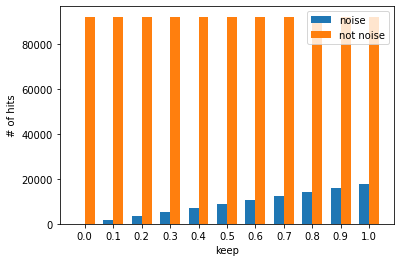

In [6]:
hits, cells, particles, truth = trackml.dataset.load_event(event_path)
pt = np.sqrt(particles.px**2 + particles.py**2 + particles.pz**2)
particles = particles.assign(pt=pt)
keeps = np.arange(0.0, 1.1, 0.1)
print(keeps)

noise_hits = []
not_noise_hits = []

for i in keeps:
    _, _, reduced_truth = remove_some_noise(hits, cells, truth, i)
    n_noise = sum(reduced_truth['particle_id'] == 0)
    noise_hits.append(n_noise)
    not_noise_hits.append(len(reduced_truth) - n_noise)

x = np.arange(len(keeps))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, noise_hits, width, label='noise')
rects2 = ax.bar(x + width/2, not_noise_hits, width, label='not noise')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('# of hits')
ax.set_xlabel('keep')
ax.set_xticks(x)
labels = ['%.1f' % (i,) for i in keeps]
ax.set_xticklabels(labels)
ax.legend()

In [7]:
from preprocess import get_one_event, load_detector

In [8]:
detector_path = "/global/homes/a/aoka/exatrkx-ctd2020/trackml/detectors.csv"
detector_orig, detector_proc = load_detector(detector_path)
event = get_one_event(event_path,detector_orig,detector_proc,True, 0.5, 0)

Loading detector...
Detector loaded.


In [9]:
event

[       hit_id           x          y       z  volume_id  layer_id  module_id  \
 0           1  -68.878403   2.077260 -1502.5          7         2          1   
 1           2  -91.987801 -10.524700 -1502.5          7         2          1   
 2           3  -54.743698  -6.891380 -1502.5          7         2          1   
 3           4  -56.549900  -6.883070 -1502.5          7         2          1   
 4           5  -55.004700 -11.325500 -1502.5          7         2          1   
 ...       ...         ...        ...     ...        ...       ...        ...   
 92213  110019 -752.534973  65.378098  2944.5         18        12         97   
 92214  110020 -783.512024  69.813599  2944.5         18        12         97   
 92215  110021 -777.473999   2.915470  2944.5         18        12         97   
 92216  110022 -974.481995  10.208400  2952.5         18        12         98   
 92217  110023 -961.247009  54.945599  2952.5         18        12         98   
 
        cell_count  cell_v